In [1]:
import numpy as np
import random
from random import randint
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import DataLoader
import torchio as tio

# Load custom files
from dataset import ImageSubjectsDataset
from model import UNet
from run import ModelRun
from visualization import plot_3d, plot_slice
from preprocessing import dataset_transform, split_dataset

seed = 128
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

import warnings
warnings.filterwarnings("ignore")

In [2]:
!tree -d -L 3

.
├── output
├── __pycache__
└── subset
    ├── subset_img
    │   ├── LUNG1-001
    │   ├── LUNG1-002
    │   ├── LUNG1-005
    │   ├── LUNG1-008
    │   ├── LUNG1-013
    │   ├── LUNG1-016
    │   ├── LUNG1-018
    │   ├── LUNG1-024
    │   ├── LUNG1-026
    │   └── LUNG1-028
    └── subset_masks
        ├── LUNG1-001
        ├── LUNG1-002
        ├── LUNG1-005
        ├── LUNG1-008
        ├── LUNG1-013
        ├── LUNG1-016
        ├── LUNG1-018
        ├── LUNG1-024
        ├── LUNG1-026
        └── LUNG1-028

25 directories


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


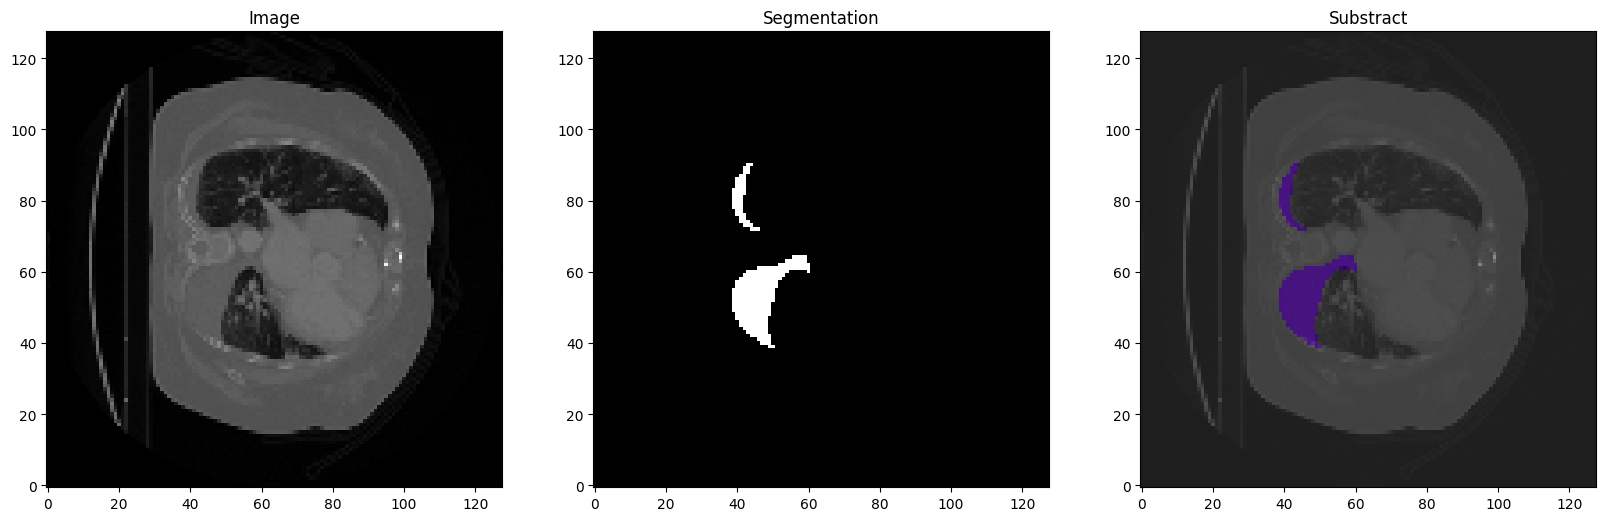

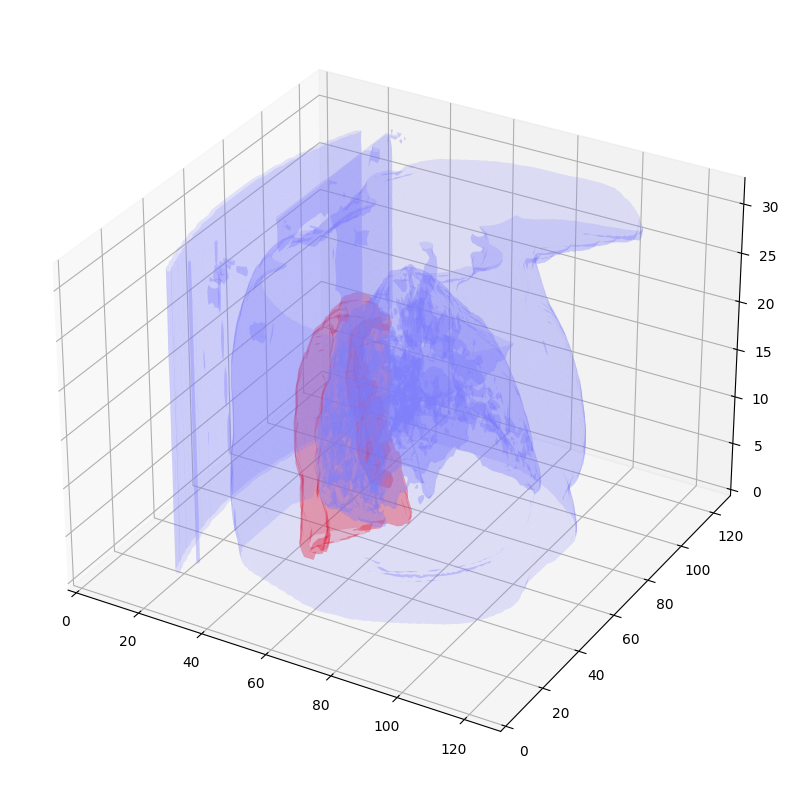

In [6]:
# Let's look at pictures
dataset = ImageSubjectsDataset(img_dir='./subset/subset_img/', mask_dir='./subset/subset_masks/', transform=dataset_transform())
batch_item = dataset.__getitem__(randint(0, dataset.__len__()-1))
plot_slice(batch_item)
plot_3d(batch_item)

In [2]:
# GPU is too weak for 5D tensors :( so, let's use CPU and take a coffee...
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
unet = UNet(num_classes=1).to(device)
summary(model, (1, 128, 128, 32), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 64, 128, 128, 32]           1,792
       BatchNorm3d-2     [-1, 64, 128, 128, 32]             128
              ReLU-3     [-1, 64, 128, 128, 32]               0
            Conv3d-4     [-1, 64, 128, 128, 32]         110,656
       BatchNorm3d-5     [-1, 64, 128, 128, 32]             128
              ReLU-6     [-1, 64, 128, 128, 32]               0
         MaxPool3d-7       [-1, 64, 64, 64, 16]               0
            Conv3d-8      [-1, 128, 64, 64, 16]         221,312
       BatchNorm3d-9      [-1, 128, 64, 64, 16]             256
             ReLU-10      [-1, 128, 64, 64, 16]               0
           Conv3d-11      [-1, 128, 64, 64, 16]         442,496
      BatchNorm3d-12      [-1, 128, 64, 64, 16]             256
             ReLU-13      [-1, 128, 64, 64, 16]               0
        MaxPool3d-14       [-1, 128, 32

In [3]:
dataset = ImageSubjectsDataset(img_dir='./subset/subset_img/', mask_dir='./subset/subset_masks/')
train_dataset, valid_dataset = split_dataset(dataset, 
                                             test_size=0.2, 
                                             train_transform=dataset_transform(augumentation=True),
                                             test_transform=dataset_transform(),
                                             seed=seed,
                                             expand_ds=4,
                                            )
train_dataset.__len__(), valid_dataset.__len__()

(40, 2)

In [4]:
train_dataloader = DataLoader(train_dataset, batch_size=1)
valid_dataloader = DataLoader(valid_dataset, batch_size=1)

model = ModelRun(unet, device)

In [5]:
%%time
model.model_train(train_dataloader, valid_dataloader, epochs=1)

Epoch: 0, train_loss: 0.151, dice_train: 0.005, valid_loss: 0.040, dice_valid: 0.007
Epoch: 10, train_loss: 0.004, dice_train: 0.248, valid_loss: 0.036, dice_valid: 0.006
Epoch: 20, train_loss: 0.003, dice_train: 0.372, valid_loss: 0.015, dice_valid: 0.252
Epoch: 30, train_loss: 0.002, dice_train: 0.488, valid_loss: 0.014, dice_valid: 0.295
Epoch: 40, train_loss: 0.002, dice_train: 0.539, valid_loss: 0.039, dice_valid: 0.057
Epoch: 50, train_loss: 0.002, dice_train: 0.520, valid_loss: 0.024, dice_valid: 0.221
Epoch: 60, train_loss: 0.002, dice_train: 0.598, valid_loss: 0.022, dice_valid: 0.261
Epoch: 70, train_loss: 0.002, dice_train: 0.518, valid_loss: 0.018, dice_valid: 0.282
Epoch: 80, train_loss: 0.002, dice_train: 0.620, valid_loss: 0.018, dice_valid: 0.319
Epoch: 90, train_loss: 0.001, dice_train: 0.668, valid_loss: 0.023, dice_valid: 0.267
Epoch: 100, train_loss: 0.001, dice_train: 0.699, valid_loss: 0.017, dice_valid: 0.333
Epoch: 110, train_loss: 0.001, dice_train: 0.687, vali

In [6]:
!tensorboard --logdir='./output/' --port 6006

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.11.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


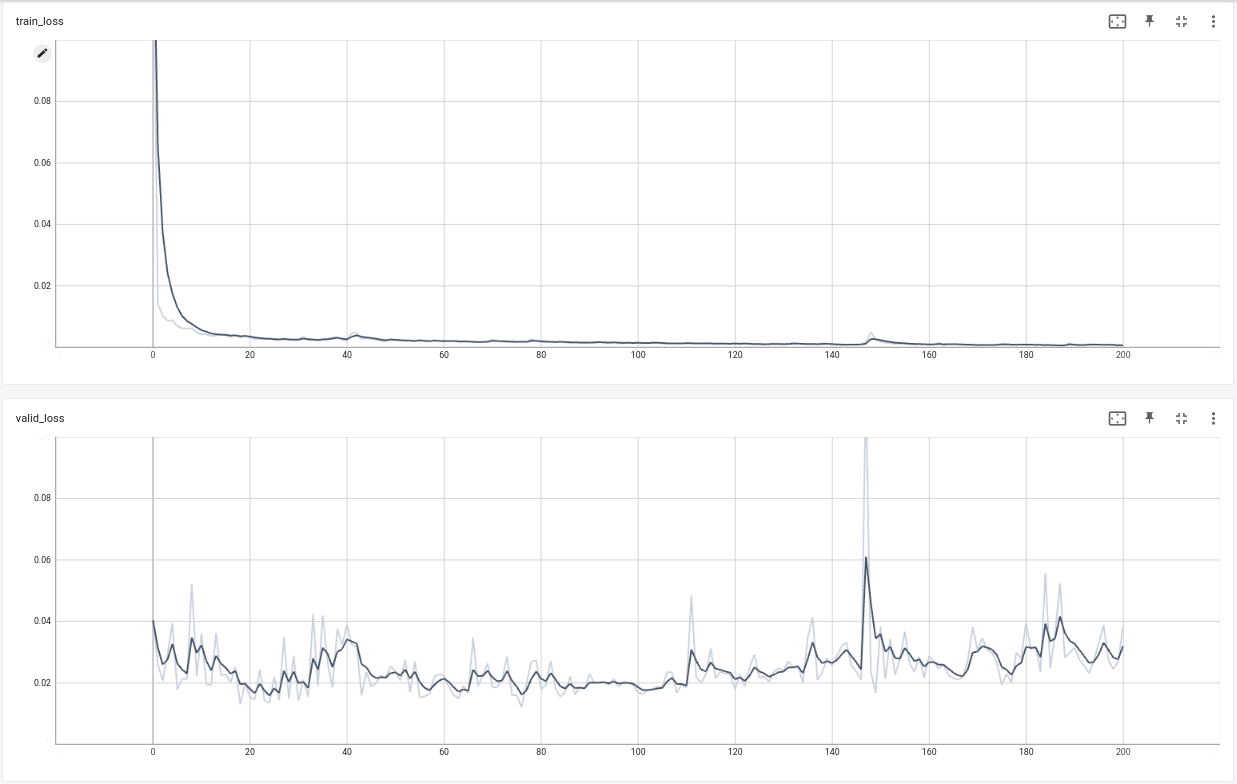

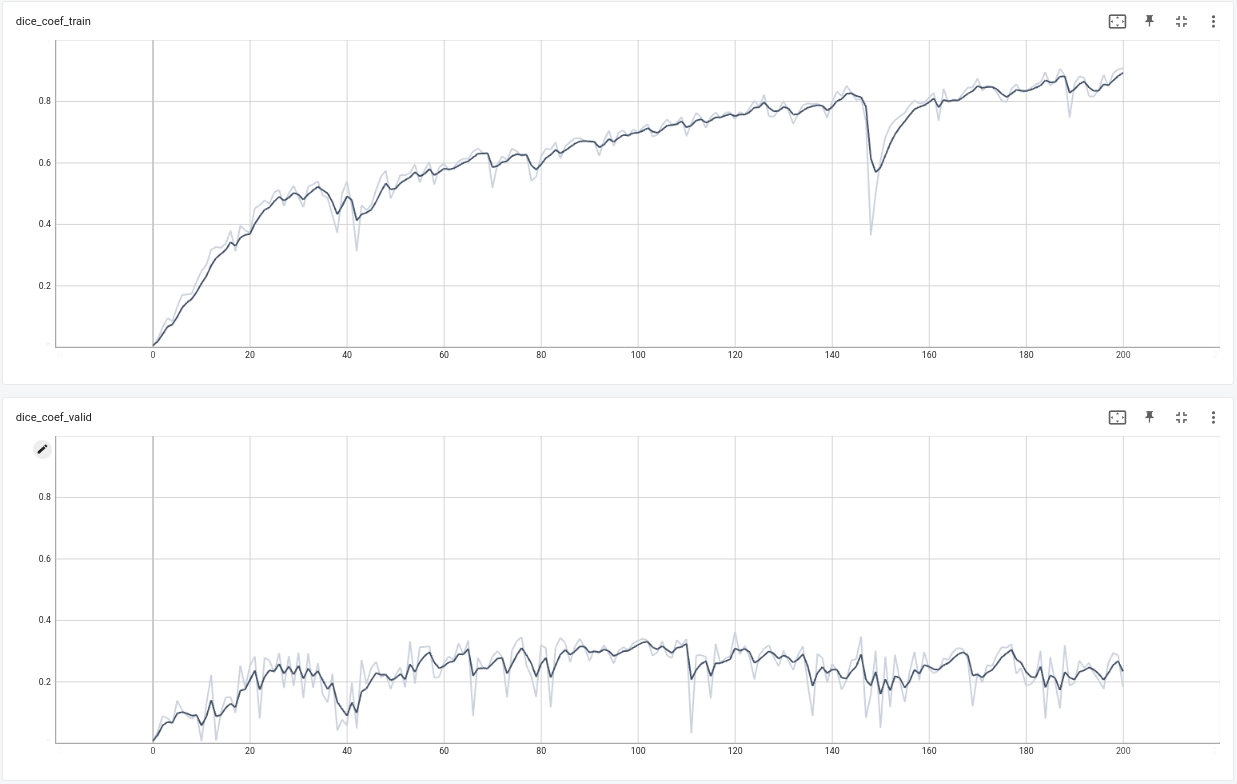

### Check the quality

In [7]:
device = 'cpu'
model = UNet(num_classes=1).to(device)
model.load_state_dict(torch.load(f'./output/best_model.pth', map_location=device))

<All keys matched successfully>

In [16]:
true_item = valid_dataset.__getitem__(0)
output = model(true_item['image']['data'].unsqueeze(0).to(device))
pred_item = tio.SubjectsDataset([tio.Subject(image = tio.ScalarImage(tensor=true_item['image']['data'].detach()),
                                             segmentation = tio.LabelMap(tensor=output.detach().squeeze(0)),
                                            )
                                ])
pred_item = pred_item.__getitem__(0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


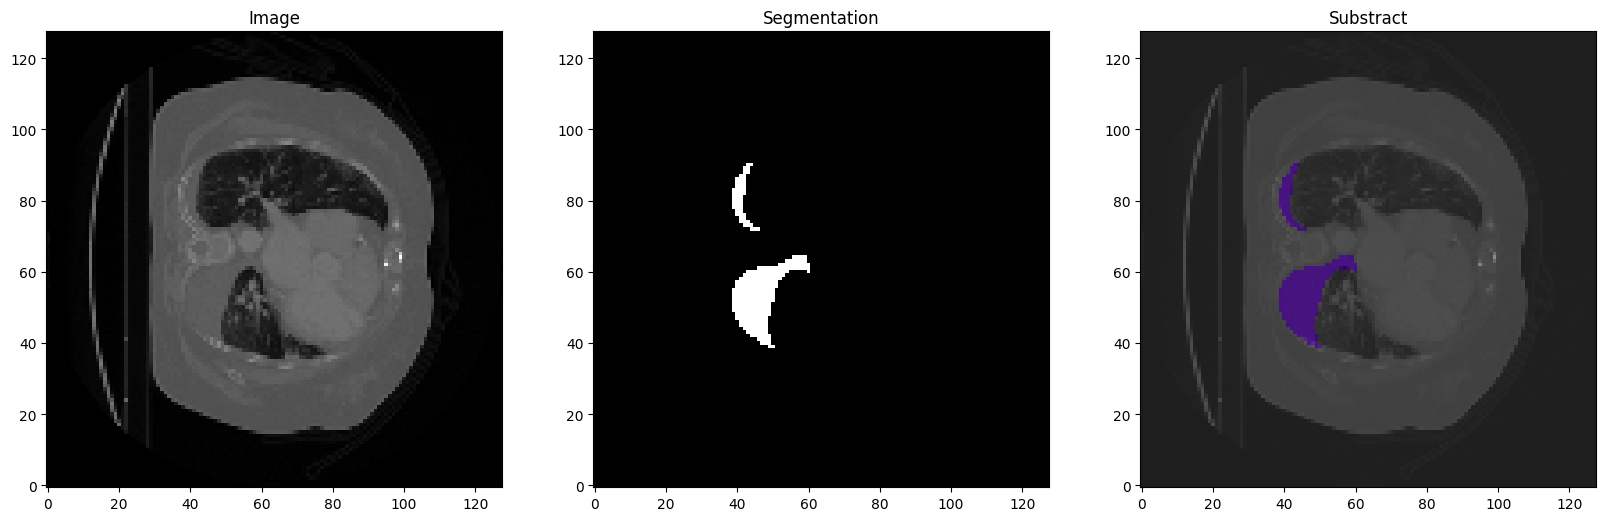

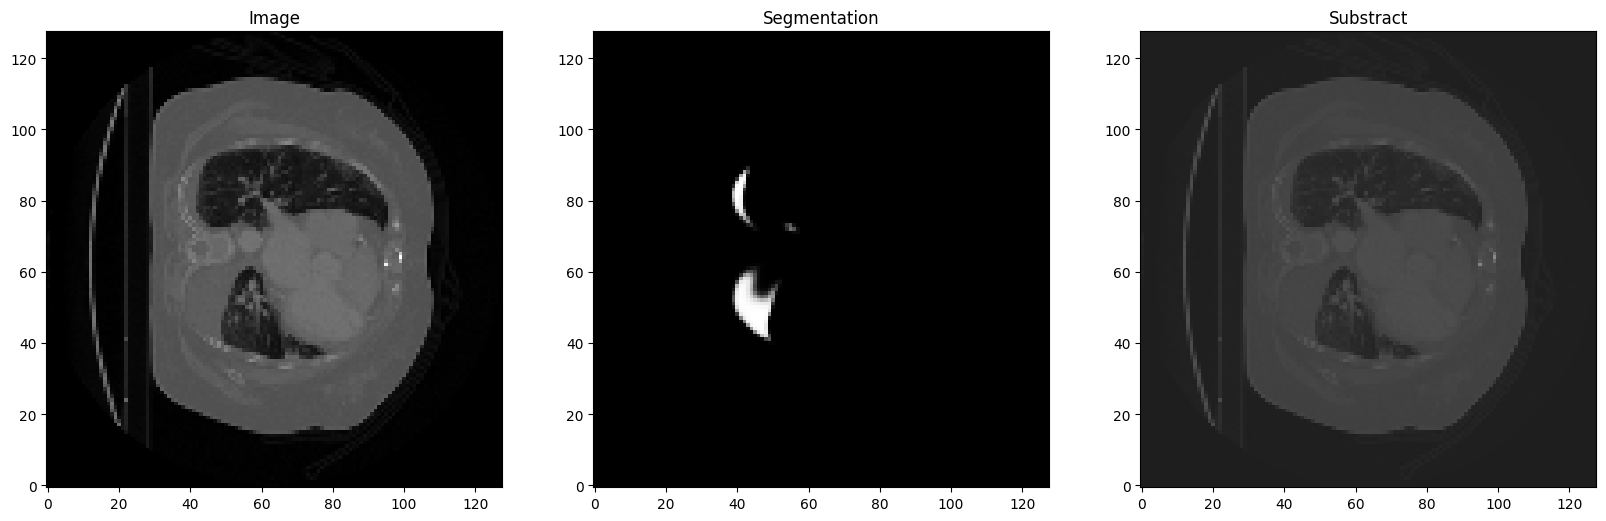

In [17]:
plot_slice(true_item, zslice=10)
plot_slice(pred_item, zslice=10)

## Summary
The model is overtrained, probably, because of a high amount of augumented data in comparing with initial dataset. To avoid this problem the next could be used for testing:
 - less augumentated data use;
 - dropout layers use instead of batchnorm layers.